# Human Protein Atlas Image Classification


Image classification of microscope slides based on mixed protein patterns.

### Project Description

The objective for this project is to determine the locations of protein organelles present in the microscope images. This breaks down into two parts: first, identifying the protein location (in general) from the image, and second, labelling each organelle within the protein.

In particular we aim to build a model that can reliably make predictions even when the images contain a mixture of different cell types with different morphologies. 

### Task 

The problem is a multi-label image classification task. Each image will contain a mixture of different cell types there are 28 in total. Therefore, the CNN must be able to predict for each image one or many of the 28 labels. 

The training images that was provided by the kaggle competition includes a train_csv file that contains a list of image ids with the identified protein labels. 


### Requirements

- keras
- tensorflow
- numpy
- pydot
- pandas
- OpenCV (opencv-python)

In [41]:
# libraries

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Activation
from keras.layers import Input, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import save_img
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import load_model
from keras import backend

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from PIL import Image as pil_image # installed by "pip install Pillow"

import cv2                      # openCV image processing
import numpy as np              # linear algebra
import pandas as pd             # data processing
import matplotlib.pyplot as plt # graphing/visualization
import h5py                     # object serialization

import os
import gc
import random
import csv
import sys
import time

### Labels
All of the 28 labels for identifying the protien. We are predicting protein organelle localization labels for each sample. The dataset was acquired in a standardized way using one imaging modality (confocal microscopy). All image samples are represented by four filters (stored as individual files), the protein of interest (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). The green filter should hence be used to predict the label, and the other filters are used as references.

In [42]:
NUCLEOPLASM                   = 0
NUCLEAR_MEMBRANE              = 1
NUCLEOLI                      = 2
NUCLEOLI_FIBRILLAR_CENTER     = 3
NUCLEAR_SPECKLES              = 4
NUCLEAR_BODIES                = 5
ENDOPLASMIC_RETICULUM         = 6
GOLGI_APPARATUS               = 7
PEROXISOMES                   = 8
ENDOSOMES                     = 9
LYSOSOMES                     = 10
INTERMEDIATE_FILAMENTS        = 11
ACTIN_FILAMENTS               = 12
FOCAL_ADHESION_SITES          = 13
MICROTUBULES                  = 14
MICROTUBULE_ENDS              = 15
CYTOKINETIC_BRIDGE            = 16
MITOTIC_SPINDLE               = 17
MICROTUBULE_ORGANIZING_CENTER = 18
CENTROSOME                    = 19
LIPID_DROPLETS                = 20
PLASMA_MEMBRANE               = 21
CELL_JUNCTIONS                = 22
MITOCHONDRIA                  = 23
AGGRESOME                     = 24
CYTOSOL                       = 25
CYTOPLASMIC_BODIES            = 26
RODS_AND_RINGS                = 27

### Some Constants
Here we define some constants that will define: the local datapath of the training, testing, and label data. We will also define some fundamental inputs to our model, such as: the number of epochs, learning rate, batch size, and the size of the subset we wish to train our data on. As we are constrained by our hardware, we will use a subset of the training data. Finally, we define a random.seed so we maintain the random numbers chosen.

In [43]:
LABELS_DIR = 'dataset'
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
TRAIN_SUBSET_SIZE = 1000 # Selection of images to train from (chosen at random, max size is 31072)
LEN_LABELS = 28

EPOCHS = 15 # epochs to train for (the more the better)
INIT_LR = 1e-3 # initial learning rate for the solver
BS = 32 # batch size
IMG_SIZE = (512, 512, 1) # 512 by 512 pixels and only one channel (black and white)

# random seed
random.seed(56732)

### Image Loading

The first step is to take our dataset and prepare it so that it's ready for our model.

Images are split into four filters/layers:
- **green**: the protein of interest
- **blue**: the nucleus
- **red**: the microtubules
- **yellow**: the endoplasmic reticulum

For this project we will mostly be interested in the **green** filter, which will be used to predict the label, while the other filters will be used as references.

In [44]:
# Get images by layer

# training set images
train_green  = [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR) if 'green'  in i]

# Select TRAIN_SUBSET_SIZE images from the training set at random
random.shuffle(train_green)
train_green = train_green[:TRAIN_SUBSET_SIZE]
train_green_ids = [i[:-10].replace((TRAIN_DIR+'/'),'') 
                       for i in train_green] # remove '_green.png' and '_green.tif'

# Retrieve the other three layers for our subset (NB: unsorted)
train_blue =   [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-9] in train_green_ids) and ('blue' in i))]
train_red =    [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-8] in train_green_ids) and ('red' in i))]
train_yellow = [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-11] in train_green_ids) and ('yellow' in i))]

# force garbage collection to make sure memory isn't wasted
gc.collect()

# test set images
test_green  = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'green'  in i]
test_blue   = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'blue'   in i]
test_red    = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'red'    in i]
test_yellow = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'yellow' in i]

In [45]:
# Testing the above by seeing if the IDs are the same

train_green.sort()
train_blue.sort()
train_red.sort()
train_yellow.sort()
#print(train_green, end='\n\n')
#print(train_blue, end='\n\n')
#print(train_red, end='\n\n')
#print(train_yellow, end='\n\n')

### Label Loading

Loading the labels from *train.csv*. Here we seek to obtain all the labels for the train and test data. These labels could be multi-label, as in indicating more then one protein may be present in any data sample.

In [46]:
train_labels = {} # dictionary with key = photo ID and entry = list of labels

# Get all the labels
with open('dataset/train.csv') as label_file:
    csvreader = csv.reader(label_file, delimiter=',', quotechar='|')
    for row in csvreader:
        if "Id" not in row[0]:
            # only take the ones that were taken in the Image Loading part
            if any(row[0] in x for x in train_green):
                train_labels[row[0]] = row[1:][0].split(' ') # labels are separated by spaces

### Image Preprocessing
We now move onto some image preprocessing after reading the data image .csv files into lists. We will now define a function to produce the input labels and output labels in a unique vector style called one hot encoding. We will also load all the training data into a pandas.dataframe with their labels. 

#### One Hot Encoding
One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.The categorical value represents the numerical value of the entry in the dataset. For example, if a training example is labelled as having NUCLEOLI_FIBRILLAR_CENTER (=3) and ENDOPLASMIC_RETICULUM  (=6), the one_hot_encoded label would be: [0 0 0 1 0 0 1 0....(28 places in total)].

In [47]:
def one_hot_encode(train_tags):
    ''' Creates a one hot encoded dictionary of all labels for each pic'''
    encoded = dict()
  
    for key in train_tags.keys():
        # create empty vector
        encoding = np.zeros(LEN_LABELS, dtype='uint8')
        # mark 1 for each tag in the vector
        for tag in train_tags[key]:
            encoding[int(tag)] = 1
            
        encoded[key] = tuple(encoding)
  
    return encoded

#### Load into Pandas
We now load every data example, and its corresponding one-hot encoded label into a pandas.dataframe for easier reference later when recalling the label as an answer. We model the training set in this way when providing answers for training the model and testing the validation of the model.

In [48]:
ohe_labels = one_hot_encode(train_labels)
training_set = pd.DataFrame.from_dict(ohe_labels, orient='index')
training_set.index.name = "Photo ID"
training_set.reset_index()
training_set.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Photo ID,,,,,,,,,,,,,,,,,,,,,
00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003feb6e-bbca-11e8-b2bc-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00626a32-bbab-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
008a780e-bb9e-11e8-b2b9-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0115f496-bbb8-11e8-b2ba-ac1f6b6435d0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0167f530-bbc1-11e8-b2bb-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
02199b60-bbc0-11e8-b2bb-ac1f6b6435d0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
025b645c-bbbe-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
02c09df8-bbc9-11e8-b2bc-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Features Visualization (using matplotlib)

As we can see the training set is highly imbalanced.
This may be indicative of the rarity of certain protein types.

Data imbalance is a well-known problem in Machine Learning. Where some classes in the dataset are more frequent than others, and the neural net just learns to predict the frequent classes.

This is a big issue, to mitigate in this case, we can easily balance the data using sampling techniques.
By removing some frequent examples(downsampling)
By creating more in-frequent examples(upsampling) using image augmentation or any other method.

Perhaps a larger data set will show more balanced results!

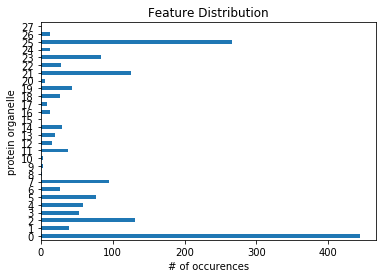

In [49]:
plt.figure()
plt.title("Feature Distribution")
plt.xlabel("# of occurences")
plt.ylabel("protein organelle")
# If this gives a boring graph, increase the subset size to look at more features.
training_set.astype(bool).sum(axis=0).plot(kind='barh')

#### Data Preprocessing

(see https://keras.io/preprocessing/image/)

This will provide real-time data augmentation later.

In [50]:
# construct the image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
              height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
              horizontal_flip=True, fill_mode="nearest")

#### Read and Process (into Keras-ready train and test sets)

In [51]:
# Based on Keras and OpenCV docs

def read_and_process(images_paths, ohe_dataframe):
    '''
    takes a panda dataframe with rows as picture IDs and columns as labels
    returns lists for keras (to be used as x and y inputs to the CNN)
    '''

    images = [] # will be used by keras as x
    labels = [] # will be used by keras as y

    for img in images_paths:
        # build image list using img_to_array() and OpenCV
        images.append(img_to_array(cv2.imread(img, cv2.IMREAD_GRAYSCALE))) # load images using cv2.imread()

        # build labels/target/tag list
        # Check labels at each step and build labels list accordingly
        # --> order is important, the lists are meant to be zip()ed
        for idx, row in ohe_dataframe.iterrows():
            if idx in img:
                labels.append(tuple(row))
    
    return np.array(images), np.array(labels)

### Test and Train splitting

Split the data from the train set into 80% training and 20% validation set.

In [52]:
# WIP
# USE sklearn.model_selection import train_test_split FOR THIS PART
X, Y = read_and_process(train_green, training_set)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=1)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(800, 512, 512, 1) (800, 28) (200, 512, 512, 1) (200, 28)


In [53]:
# train_x, train_y = read_and_process(train_green, training_set)
# test_x,  test_y  = read_and_process(validation_green, training_set)

### CNN Setup

Now that the preprocessing is out of the way, we can build our CNN structure.

This will be a smaller implementation of *VGGNet*, as described here: https://arxiv.org/pdf/1409.1556/

#### Input Layer Setup


In [54]:
model = Sequential()
height, width, depth = IMG_SIZE
input_shape = (height, width, depth) # derived from image size
chanDim = -1
classes = LEN_LABELS # number of classification classes

# if we are using "channels first", update the input shape
# and channels dimension
if backend.image_data_format() == "channels_first":
    input_shape = (depth, height, width)
    chanDim = 1

#### Conv + ReLU + Pool Blocks

Increasing filter sizes help increase depth.

In [55]:
# First CONV => RELU => POOL block
model.add(Conv2D(16, (3, 3), padding="valid", input_shape=input_shape)) # 32 filters and a 3x3 kernel
model.add(Activation("relu")) # standard activation layer
model.add(BatchNormalization(axis=chanDim)) # normalize all inputs to the [0, 1] range
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25)) # dropout will reduce overfitting by randomly dropping 25% of node connections

# (CONV => RELU) * 2 => POOL (first double convolution before pooling)
model.add(Conv2D(32, (3, 3), padding="valid")) # 64 filters and 3x3 kernel
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2))) # smaller pool size this time to reduce spatial size
model.add(Dropout(0.25))
 
# (CONV => RELU) * 2 => POOL (second double convolution before pooling)
model.add(Conv2D(64, (3, 3), padding="valid")) # 128 filters and 3x3 kernel
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL (third double convolution before pooling)
model.add(Conv2D(128, (3, 3), padding="valid")) # 128 filters and 3x3 kernel
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#### Fully Connected + ReLU block

In [56]:
# first (and only) set of FC => RELU layers
model.add(Flatten()) # Collapses the spatial dimensions of the input into the channel dimensions
model.add(Dense(1024)) # dense layer of neurons with 1024 being the dimensionality of the output space
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) # Dropout of 50%

# Since this is multi-label classification we use the sigmoid activation function
model.add(Dense(classes)) # output dimensionality equal to the number of output classes
model.add(Activation("sigmoid"))

##I think we want "softmax" not sigmoid, any picture may be multiple 1's

#### Optimizer

In [57]:
# opt = SGD(lr=0.01, momentum=0.9) # Stochastic Gradient Descent with 0.01 learning rate
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS) # Adam will provide results faster than SGD with similar quality

#### FBeta Score , Precision, and Recall Functions

We must define our performance metrics before compiling the model.

In [58]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

# calculate precision
def precision(y_true, y_pred):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    
    return p

# calculate recall
def recall(y_true, y_pred):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    
    return r


#### Model Compilation

In [59]:
# Since we're using checkpoints we need to load the model from disk, if possible
try:
    model = load_model('model.h5')
except OSError:
    # Otherwise we compile from scratch

    # We use binary cross-entropy as this is multilabel multicategory classification
    # For metrics we look at accuracy but also a more advanced metric for multilabel classification called the F-beta score
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', precision, recall, fbeta])

#### Model Summary

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 510, 510, 16)      160       
_________________________________________________________________
activation_15 (Activation)   (None, 510, 510, 16)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 510, 510, 16)      64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 170, 170, 16)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 170, 170, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 168, 168, 32)      4640      
_________________________________________________________________
activation_16 (Activation)   (None, 168, 168, 32)     

#### Set up Checkpoints

We'll automatically save the best model to disk so that we can resume training on it later.

Different metrics can be chosen to determine the "best" model.

In [40]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_fbeta', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint] # callbacks list used by Keras

### Training

In [25]:
# train the network

# With data augmentation
#hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=BS),
#            validation_data=(testX, testY),
#            steps_per_epoch=(len(trainX) // BS),
#            epochs=EPOCHS, verbose=1)

# Without data augmentation
hist = model.fit(trainX, trainY,
                batch_size=BS,
                validation_data=(testX, testY),
                epochs=EPOCHS, callbacks=callbacks_list,
                verbose=1)

Train on 25 samples, validate on 7 samples
Epoch 1/25


KeyboardInterrupt: 

### Validation

#### Diagnostics Visualization

In [ ]:
# WIP
def summarize_diagnostics(history):
    # plot loss 
    plt.subplot(411)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(412)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    #plot precision
    plt.subplot(413)
    plt.title('Precision')
    plt.plot(history.history['precision'], color='blue', label='train')
    plt.plot(history.history['val_precision'], color='orange', label='train')
    #plot recall
    plt.subplot(414)
    plt.title('Recall')
    plt.plot(history.history['recall'], color='blue', label='train')
    plt.plot(history.history['val_recall'], color='orange', label='train')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')

In [ ]:
summarize_diagnostics(hist)
#precision = true positives / (true positives + false positives)
#recall = true positives / (true positives + false negatives)
#fbeta ==> generalized f1 score derived from both precision and recall averaged over all classes


### Convolutional Filter Visualization

based on https://keras.io/examples/conv_filter_visualization/

#### Utility Functions

In [24]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (backend.sqrt(backend.mean(backend.square(x))) + backend.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + backend.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if backend.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if backend.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if backend.image_data_format() == 'channels_first':
            loss = backend.mean(layer_output[:, filter_index, :, :])
        else:
            loss = backend.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = backend.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = backend.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if backend.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= backend.epsilon():
                    return None

            # Calculate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

#### Running the Script

This script will help us visualize what the convolutional layers are learning.

Unfortunately because of a TensorFlow issue it only works if images are read
with cv2.IMREAD_COLOR and an RGB channel depth in image_size. 



In [25]:
conv_layers = [l.name for l in model.layers if 'conv2d' in l.name]
print(conv_layers)

['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5']


In [ ]:
for layer_name in conv_layers[2:]:
    try:
        visualize_layer(model, layer_name)
    except Exception as e:
        print("This model isn't compatible with the script. Sorry!")
        print(str(e))
        break

Compute filters 0 to 64
Costs of filter   2:     9 ( 8.83s )
Costs of filter   4:     7 ( 9.06s )
Costs of filter   5:    13 ( 8.96s )
Costs of filter   9:    10 ( 9.17s )
Costs of filter  14:     4 ( 9.64s )
Costs of filter  19:    14 ( 9.95s )
Costs of filter  26:     6 ( 10.89s )
Costs of filter  33:     7 ( 22.39s )
Costs of filter  34:     7 ( 16.06s )
Costs of filter  36:    11 ( 13.84s )
Costs of filter  37:    10 ( 14.36s )
Costs of filter  39:    16 ( 15.93s )
Costs of filter  45:    13 ( 21.25s )
Costs of filter  52:     8 ( 15.19s )
Costs of filter  56:    13 ( 16.15s )
Costs of filter  57:     9 ( 17.57s )
Costs of filter  59:    11 ( 17.04s )
Costs of filter  60:    13 ( 21.69s )
Costs of filter  61:     7 ( 21.89s )
